# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

### Main blocks of code:
* Dataset import
* Data Exploration & Cleaning
* Merging datasets
* Model & prediction & evaluation
* Conclusion

#### Question to be answered:
* Which age groups complete the offer?
* How well can we predict the success of offers?

### Importing libraries and datasets

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
from time import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,f1_score
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration & Cleaning

#### Portfolio dataset (df: portfolio > po)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
portfolio['id'].nunique()

10

In [6]:
# copying portfolio df for encoding
po = portfolio.copy()

In [7]:
# encoding channels 
mlb = MultiLabelBinarizer()
channel = pd.DataFrame(mlb.fit_transform(po['channels']), columns=mlb.classes_, index=po.index)

# dropping channels column with new channel columns
po = po.drop(['channels'], axis=1)

# concatenating the original 'po' df with new channel df
po = pd.concat([po,channel], join='inner', axis=1)
po

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [8]:
# encoding offer types 
offer_type = pd.get_dummies(po['offer_type'])

po = pd.concat([po, offer_type], join='inner', axis=1)
po

,difficulty,duration,id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


In [9]:
# change duration days column to duration hours
po['duration'] = po['duration'] * 24
po

,difficulty,duration,id,offer_type,reward,email,mobile,social,web,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


In [10]:
# renaming id column to offer_id
po.rename(columns={'difficulty':'offer_required_spending', 'duration':'offer_open_days','id': 'offer_id', 'reward':'offer_reward', 'bogo':'offer_bogo', 'discount':'offer_discount', 'informational':'offer_informational'}, inplace=True)
po.head(2)

,offer_required_spending,offer_open_days,offer_id,offer_type,offer_reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0


#### Profile dataset (df: profile > pf)

In [11]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [12]:
profile.shape

(17000, 5)

In [13]:
pf = profile.copy()

In [14]:
#converting became_member_on to date
pf['became_member_on'] = pd.to_datetime(pf['became_member_on'], format='%Y%m%d')
pf.head(10)

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN


In [15]:
# adding total days of membership, as the date of today - date of became member

def create_days(pf):
    '''
    Input: it takes the current date and extract the date of became a member
    Output: number of days of membership
    '''
    current_date = pd.to_datetime('today')
    
    return(current_date - pf['became_member_on'])

pf['membership_days'] = pf.apply(create_days, axis=1)
pf['membership_days'] = pf['membership_days'].dt.days
pf.drop(['became_member_on'], axis=1, inplace=True)

pf.head()

,age,gender,id,income,membership_days
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1513
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1360
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,998
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1427
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,1340


In [16]:
pf['gender'].nunique()

3

In [17]:
# encoding gender column
pf['gender'] = pf['gender'].apply(lambda x: 1 if x =='M' else 2 if x == 'F' else 0)
pf.head(10)

,age,gender,id,income,membership_days
0,118,0,68be06ca386d4c31939f3a4f0e3dd783,NaN,1513
1,55,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360
2,118,0,38fe809add3b4fcf9315a9694bb96ff5,NaN,998
3,75,2,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1427
4,118,0,a03223e636434f42ac4c3df47e8bac43,NaN,1340
5,68,1,e2127556f4f64592b11af22de27a7932,70000.0,1075
6,118,0,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,1288
7,118,0,68617ca6246f4fbc85e91a2a49552598,NaN,1281
8,65,1,389bc3fa690240e798340f5a15918d5c,53000.0,1151
9,118,0,8974fc5686fe429db53ddde067b88302,NaN,1595


In [18]:
pf['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
59      359
57      353
52      351
55      350
56      342
63      338
60      333
49      321
62      318
67      317
64      311
61      309
48      288
50      284
66      284
65      280
68      259
70      252
69      242
47      232
45      231
71      230
42      227
43      215
46      212
       ... 
22      131
30      131
29      129
23      126
81      118
35      118
79      117
80      116
31      113
82      105
83      102
84       83
18       70
85       70
87       66
88       64
86       54
89       53
90       52
91       47
92       40
94       33
93       29
95       22
97       13
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [19]:
pf[pf.age == 118][['gender', 'age', 'income']]

,gender,age,income
0,0,118,NaN
2,0,118,NaN
4,0,118,NaN
6,0,118,NaN
7,0,118,NaN
9,0,118,NaN
10,0,118,NaN
11,0,118,NaN
17,0,118,NaN
23,0,118,NaN


In [20]:
# 118 represents missing values
pf['age'] = pf['age'].apply(lambda x: np.nan if x == 118 else x)
# dropping these missing values
pf.dropna(inplace=True)
pf.head(20)

,age,gender,id,income,membership_days
1,55.0,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360
3,75.0,2,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1427
5,68.0,1,e2127556f4f64592b11af22de27a7932,70000.0,1075
8,65.0,1,389bc3fa690240e798340f5a15918d5c,53000.0,1151
12,58.0,1,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1241
13,61.0,2,aa4862eba776480b8bb9c68455b8c2e1,57000.0,1302
14,26.0,1,e12aeaf2d47d42479ea1c4ac3d8286c6,46000.0,2608
15,62.0,2,31dda685af34476cad5bc968bdb01c53,71000.0,1880
16,49.0,1,62cf5e10845442329191fc246e7bcea3,52000.0,2335
18,57.0,1,6445de3b47274c759400cd68131d91b4,42000.0,1191


In [21]:
pf.shape

(14825, 5)

In [22]:
pf.duplicated().sum()

0

In [23]:
# renaming id column to member_id
pf.rename(columns={'id': 'member_id'}, inplace=True)
pf.head(2)

,age,gender,member_id,income,membership_days
1,55.0,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360
3,75.0,2,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1427


#### Transcript dataset (df: transcript > ts)

In [24]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [25]:
transcript.shape

(306534, 4)

In [26]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [27]:
# copying transcript df
ts = transcript.copy()

In [28]:
# renaming person column to member_id
ts.rename(columns={'person': 'member_id'}, inplace=True)
ts.head(2)

,event,member_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [29]:
ts.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [30]:
# encoding event
ts['event'] = ts['event'].map({'offer received':1, 'offer viewed':2, 'transaction':3, 'offer completed':4 })
ts.head()

,event,member_id,time,value
0,1,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,1,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,1,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,1,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [31]:
ts.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [32]:
# extracting values from value column 
ts = pd.concat([ts, ts['value'].apply(pd.Series)], axis=1)
ts.head()

,event,member_id,time,value,offer id,amount,offer_id,reward
0,1,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,1,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,1,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,1,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [33]:
# cleaning duplicated columns
ts['offer_id_new']=np.where(ts['offer id'].isnull() & ts['offer_id'].notnull(),ts['offer_id'],ts['offer id'])

# dropping unnecessary offer_id columns
ts.drop(['offer id','offer_id'],axis=1,inplace=True)

# renaming offer_id column
ts.rename(columns={'offer_id_new':'offer_id'},inplace=True)

# dropping value column
ts.drop(['value'], axis=1, inplace=True)

ts.head()

,event,member_id,time,amount,reward,offer_id
0,1,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,1,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,1,e2127556f4f64592b11af22de27a7932,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,1,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,1,68617ca6246f4fbc85e91a2a49552598,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [34]:
# offer groups
ts.offer_id.value_counts()

fafdcd668e3743c1bb461111dcafc2a4    20241
2298d6c36e964ae4a3e7e9706d1fb8c2    20139
f19421c1d4aa40978ebb69ca19b0e20d    19131
4d5c57ea9a6940dd891ad53e9dbe8da0    18222
ae264e3637204a6fb9bb56bc8210ddfd    18062
9b98b8c7a33c4b65b9aebfe6a799e6d9    16202
2906b810c7d4411798c6938adc9daaa5    15767
5a8bc65990b245e5a138643cd4eb9837    14305
0b1e1539f2cc45b7b9fa7c272da2e1d7    13751
3f207df678b143eea3cee63160fa8bed    11761
Name: offer_id, dtype: int64

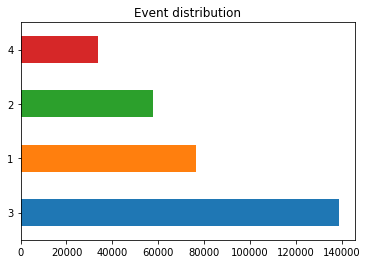

In [35]:
# creating a bar chart for plotting the event distribution
ts['event'].value_counts().plot.barh(title='Event distribution')

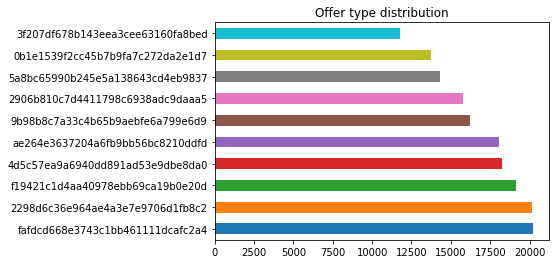

In [36]:
ts['offer_id'].value_counts().plot.barh(title='Offer type distribution')

### Merging datasets

In [37]:
df_member_id = pd.merge(pf, ts, on='member_id')
df = pd.merge(df_member_id, po, how="left", on='offer_id')
df.head(3)

,age,gender,member_id,income,membership_days,event,time,amount,reward,offer_id,...,offer_open_days,offer_type,offer_reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,55.0,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360,3,18,21.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55.0,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360,3,144,32.28,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55.0,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360,1,408,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,168.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0


In [38]:
df.shape

(272762, 21)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 21 columns):
age                        272762 non-null float64
gender                     272762 non-null int64
member_id                  272762 non-null object
income                     272762 non-null float64
membership_days            272762 non-null int64
event                      272762 non-null int64
time                       272762 non-null int64
amount                     123957 non-null float64
reward                     32444 non-null float64
offer_id                   148805 non-null object
offer_required_spending    148805 non-null float64
offer_open_days            148805 non-null float64
offer_type                 148805 non-null object
offer_reward               148805 non-null float64
email                      148805 non-null float64
mobile                     148805 non-null float64
social                     148805 non-null float64
web                        148805 

In [40]:
# change offer_id to integers
df['offer_id'] = df['offer_id'].map({'fafdcd668e3743c1bb461111dcafc2a4':1, '2298d6c36e964ae4a3e7e9706d1fb8c2':2, 'f19421c1d4aa40978ebb69ca19b0e20d':3, '4d5c57ea9a6940dd891ad53e9dbe8da0':4, 'ae264e3637204a6fb9bb56bc8210ddfd':5, '9b98b8c7a33c4b65b9aebfe6a799e6d9':6, '2906b810c7d4411798c6938adc9daaa5':7, '5a8bc65990b245e5a138643cd4eb9837':8, '0b1e1539f2cc45b7b9fa7c272da2e1d7':9, '3f207df678b143eea3cee63160fa8bed':10})
df.head()

,age,gender,member_id,income,membership_days,event,time,amount,reward,offer_id,...,offer_open_days,offer_type,offer_reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,55.0,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360,3,18,21.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55.0,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360,3,144,32.28,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55.0,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360,1,408,NaN,NaN,6.0,...,168.0,bogo,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,55.0,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360,1,504,NaN,NaN,10.0,...,96.0,informational,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,55.0,2,0610b486422d4921ae7d2bf64640c50b,112000.0,1360,3,528,23.22,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# dropping columns before prediction
df.drop(['member_id', 'offer_type'], axis=1, inplace=True)
df.head()

,age,gender,income,membership_days,event,time,amount,reward,offer_id,offer_required_spending,offer_open_days,offer_reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,55.0,2,112000.0,1360,3,18,21.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,55.0,2,112000.0,1360,3,144,32.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55.0,2,112000.0,1360,1,408,NaN,NaN,6.0,5.0,168.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,55.0,2,112000.0,1360,1,504,NaN,NaN,10.0,0.0,96.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,55.0,2,112000.0,1360,3,528,23.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# fill nan with 0
df = df.fillna(0)
df.head()

,age,gender,income,membership_days,event,time,amount,reward,offer_id,offer_required_spending,offer_open_days,offer_reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,55.0,2,112000.0,1360,3,18,21.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55.0,2,112000.0,1360,3,144,32.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,55.0,2,112000.0,1360,1,408,0.00,0.0,6.0,5.0,168.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,55.0,2,112000.0,1360,1,504,0.00,0.0,10.0,0.0,96.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,55.0,2,112000.0,1360,3,528,23.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# save cleaned file 
df.to_csv('data/cleaned_data.csv', index=False)

In [44]:
# read cleaned file
df = pd.read_csv('data/cleaned_data.csv')
df.head()

,age,gender,income,membership_days,event,time,amount,reward,offer_id,offer_required_spending,offer_open_days,offer_reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational
0,55.0,2,112000.0,1360,3,18,21.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55.0,2,112000.0,1360,3,144,32.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,55.0,2,112000.0,1360,1,408,0.00,0.0,6.0,5.0,168.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,55.0,2,112000.0,1360,1,504,0.00,0.0,10.0,0.0,96.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,55.0,2,112000.0,1360,3,528,23.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


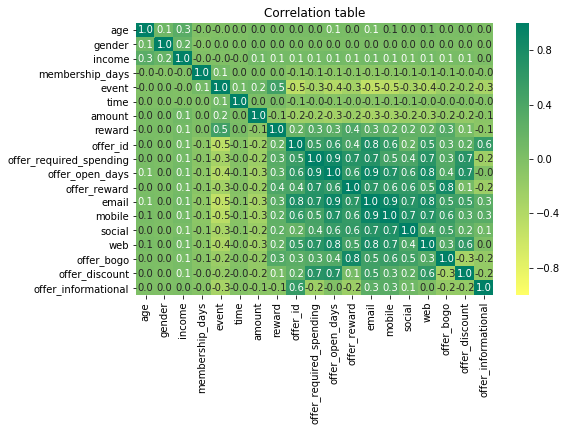

In [45]:
# creating a correlation table
df_corr = df.corr()
plt.figure(figsize=(8,5))
sns.heatmap(data=df_corr, annot=True, fmt=".1f", vmin=-1, vmax=1, cmap="summer_r")
plt.yticks(rotation=0)
plt.title('Correlation table')
plt.show()

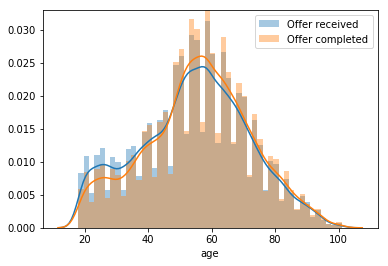

In [46]:
# creating a distribution column chart of offer received and completed per age group
sns.distplot(df[df.event == 1].age, label = 'Offer received')
sns.distplot(df[df.event == 4].age, label = 'Offer completed')
plt.legend()
plt.show()

In [91]:
# creating a new column to determine which project was successful
df['successful_offer'] = ((df['event'] == 4) | (df['reward'] > 0))
df['successful_offer'] = df['successful_offer'].astype(int)
df.head()

,age,gender,income,membership_days,event,time,amount,reward,offer_id,offer_required_spending,offer_open_days,offer_reward,email,mobile,social,web,offer_bogo,offer_discount,offer_informational,successful_offer
0,55.0,2,112000.0,1360,3,18,21.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,55.0,2,112000.0,1360,3,144,32.28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,55.0,2,112000.0,1360,1,408,0.00,0.0,6.0,5.0,168.0,5.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0
3,55.0,2,112000.0,1360,1,504,0.00,0.0,10.0,0.0,96.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0
4,55.0,2,112000.0,1360,3,528,23.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [92]:
df.columns

Index(['age', 'gender', 'income', 'membership_days', 'event', 'time', 'amount',
       'reward', 'offer_id', 'offer_required_spending', 'offer_open_days',
       'offer_reward', 'email', 'mobile', 'social', 'web', 'offer_bogo',
       'offer_discount', 'offer_informational', 'successful_offer'],
      dtype='object')

### Modeling & Prediction

Building a ML model to predict the success of an offer

In [93]:
# defining variables and targets
X = df[['age', 'gender', 'income', 'membership_days', 'time', 'offer_id', 'offer_required_spending', 'offer_open_days',
       'offer_reward', 'email', 'mobile', 'social', 'web', 'offer_bogo',
       'offer_discount', 'offer_informational']]
y = df['successful_offer']

In [94]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 42)

In [95]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((182750, 16), (90012, 16), (182750,), (90012,))

#### Logistic Regression

In [96]:
# fitting the model
lrm = LogisticRegression()
lrm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
# calculating accuracy for train
print("LR model train: {0:.2f}%".format(lrm.score(X_train, y_train)*100))

LR model train: 86.78%


In [98]:
# prediction
lrm_y_preds_test = lrm.predict(X_test)

In [99]:
# calculating accuracy for test
print("LR model test: {0:.2f}%".format(lrm.score(X_test, y_test)*100))

LR model test: 87.05%


#### Decision Tree Classifier Model

In [100]:
# fitting the model
dtm = DecisionTreeClassifier()
dtm.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [101]:
# calculating accuracy for train
print("DT model train: {0:.2f}%".format(dtm.score(X_train, y_train)*100))

DT model train: 98.93%


In [102]:
# prediction
dtm_y_preds_test = dtm.predict(X_test)

In [103]:
# calculating accuracy for test
print("DT model test: {0:.2f}%".format(dtm.score(X_test, y_test)*100))

DT model test: 87.70%


#### Random Forest Regressor Model

In [104]:
# fitting the model
rfm = RandomForestRegressor(n_estimators=10, min_samples_leaf=20)
rfm.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [105]:
# calculating accuracy for train
print("RF model train: {0:.2f}%".format(rfm.score(X_train, y_train)*100))

RF model train: 51.19%


In [106]:
# prediction
rfm_y_preds_test = rfm.predict(X_test)

In [107]:
# calculating accuracy for test
print("RF model test: {0:.2f}%".format(rfm.score(X_test, y_test)*100))

RF model test: 41.63%


### Conclusion

With Decision Tree Classifier, we can predict 87.7%, whether the offer will be completed.